In [1]:
import os
import cv2
import torch
import pandas as pd
import torch.nn as nn
import albumentations
import matplotlib.pyplot as plt


from train import train
from source.network import ConvRNN
from utils import load_obj, save_obj
from source.dataset import TRSynthDataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
epochs = 100
batch_size = 32
model_path = "models/model.pth"
char2int_path = "data/char2int.pkl"
int2char_path = "data/int2char.pkl"
data_file_path = "data/data_file.csv"
image_path = "data/images"
label_path = "data/labels.txt"

### Inspect some images

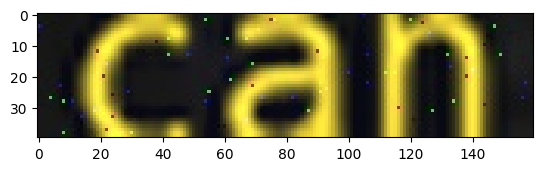

In [3]:
img = plt.imread(os.path.join(image_path,"00000008.jpg"))
plt.imshow(img)
plt.show()

### Check corresponding label

In [4]:
labels = pd.read_table(label_path, header=None)

In [5]:
labels.head()

,0
0,life
1,not
2,while
3,know
4,clearly


In [6]:
labels.iloc[1,0]

'not'

In [7]:
labels.shape

(100000, 1)

### Total number of images

In [8]:
len(os.listdir(image_path))

100000

### Find null values in labels

In [9]:
labels.isna().sum()

0    6
dtype: int64

In [10]:
labels[labels[0].isna()]

,0
17672,NaN
19198,NaN
33301,NaN
57410,NaN
74347,NaN
77150,NaN


### Let's check those images

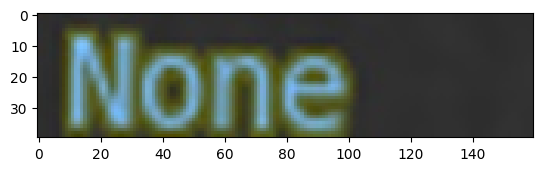

In [11]:
img = plt.imread(os.path.join(image_path, "00017672.jpg"))
plt.imshow(img)
plt.show()

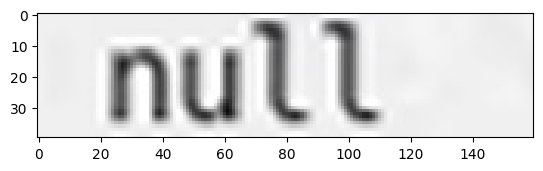

In [12]:
img = plt.imread(os.path.join(image_path, "00074347.jpg"))
plt.imshow(img)
plt.show()

### Replace those missing values with the string "null"

In [13]:
labels.fillna("null", inplace=True)

### Create a dataframe with image paths and corresponding labels

In [14]:
image_files = os.listdir(image_path)
image_files.sort()
image_files = [os.path.join(image_path, i) for i in image_files]

In [15]:
data_file = pd.DataFrame({"images": image_files, "labels": labels[0]})
data_file.to_csv(data_file_path, index=False)

In [16]:
data_file.head()

,images,labels
0,data/images\00000000.jpg,life
1,data/images\00000001.jpg,not
2,data/images\00000002.jpg,while
3,data/images\00000003.jpg,know
4,data/images\00000004.jpg,clearly


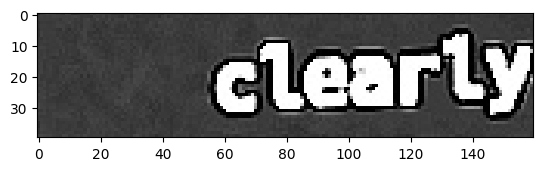

In [17]:
img = plt.imread(os.path.join(image_path, "00000004.jpg"))
plt.imshow(img)
plt.show()

### Find the unique characters in the labels

In [18]:
unique_chars = list({l for word in labels[0] for l in word})
unique_chars.sort()

In [19]:
unique_chars

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [20]:
len(unique_chars)

81

### Create mapping from characters to integer and integer to character and save them to disc

In [21]:
char2int = {a: i+1 for i, a in enumerate(unique_chars)}
int2char = {i+1: a for i, a in enumerate(unique_chars)}

In [22]:
save_obj(char2int, char2int_path)
save_obj(int2char, int2char_path)

# Training the model

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

### Split the data into train and validation

In [24]:
train_file, valid_file = train_test_split(data_file, test_size=0.2)

### Create train and validation datasets

In [25]:
train_dataset = TRSynthDataset(train_file, char2int)
valid_dataset = TRSynthDataset(valid_file, char2int)

### Define the loss function

In [26]:
criterion = nn.CTCLoss(reduction="sum")
criterion.to(device)

CTCLoss()

### Number of classes

In [27]:
n_classes = len(char2int)

### Create the model object

In [28]:
model = ConvRNN(n_classes)
model.to(device)

ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

### Define Optimizer

In [29]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

### Define train and validation data loaders

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           drop_last=False)

### Training loop

In [76]:
for i in range(epochs):
    print(f"Epoch {i+1} of {epochs}...")
    # Run train function
    train_loss = train(model, train_loader, criterion, device, optimizer, test=False)
    # Run validation function
    valid_loss = train(model, valid_loader, criterion, device, test=True)
    print(f"Train Loss: {round(train_loss,4)}, Valid Loss: {round(valid_loss,4)}")
    # if valid_loss < best_loss:
    #     print("Validation Loss improved, saving Model File...")
    #     # Save model object
    #     torch.save(model.state_dict(), model_path)
    #     best_loss = valid_loss

Epoch 1 of 100...


  0%|          | 2/2500 [00:24<8:29:51, 12.25s/it]


KeyboardInterrupt: 

### Load the trained model

In [31]:
model = ConvRNN(n_classes)
model.load_state_dict(torch.load(model_path, 
                                map_location=torch.device('cpu')))

# Set model mode to evaluation
model.eval()

ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

# Prediction

### Pick a test image

In [108]:
test_img = os.path.join(image_path, "B3.jpg")
img = cv2.imread(test_img)

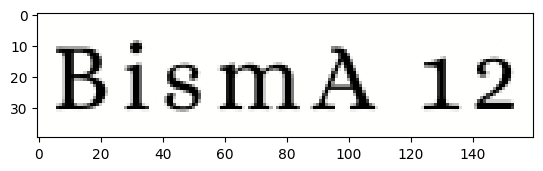

In [109]:
plt.imshow(plt.imread(test_img))
plt.show()

### Apply augmentations

In [110]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
img_aug = albumentations.Compose(
        [albumentations.Normalize(mean, std,
                                  max_pixel_value=255.0,
                                  always_apply=True)]
    )
augmented = img_aug(image=img)
img = augmented["image"]
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img)
# Create batch dimension (batch of single image)
img = torch.unsqueeze(img, 0)
# Move the image array to CUDA if available
img = img.to(device)

### Take model output

In [111]:
out = model(img)

### Apply softmax and take label predictions

In [112]:
out = torch.squeeze(out, 0)
out = out.softmax(1)
pred = torch.argmax(out, 1)

In [113]:
pred.shape

torch.Size([40])

In [114]:
pred = pred.tolist()

In [115]:
pred

[0,
 0,
 0,
 0,
 31,
 0,
 0,
 0,
 64,
 0,
 0,
 0,
 74,
 0,
 0,
 0,
 0,
 69,
 0,
 69,
 0,
 0,
 0,
 0,
 30,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 16,
 0,
 0]

In [116]:
int2char[56]

'a'

### Use 'ph' for special character

In [117]:
int2char[0] = "ph"

### Convert integer predictions to string

In [118]:
out = [int2char[i] for i in pred]

In [119]:
out

['ph',
 'ph',
 'ph',
 'ph',
 'B',
 'ph',
 'ph',
 'ph',
 'i',
 'ph',
 'ph',
 'ph',
 's',
 'ph',
 'ph',
 'ph',
 'ph',
 'n',
 'ph',
 'n',
 'ph',
 'ph',
 'ph',
 'ph',
 'A',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 '1',
 'ph',
 'ph',
 'ph',
 'ph',
 '2',
 'ph',
 'ph']

### Collapse the output

In [120]:
res = list()
res.append(out[0])
for i in range(1, len(out)):
    if out[i] != out[i - 1]:
        res.append(out[i])
res = [i for i in res if i != "ph"]
res = "".join(res)

In [121]:
print(res)

BisnnA12
